# Boli perturb ctx edit ntsubset hvg

In [1]:
import scanpy as sc
raw = sc.read_h5ad("/gpfs/home/asun/jin_lab/database/boli_perturb_ctx_edit_ntsubset_hvg/processed/gloria/adata.h5ad")


In [2]:
raw.obs["Assign"].value_counts()

Assign
Bcl11b_0    5367
Trio_0      4274
Dab1_0      4123
Tbr1_0      3466
NT_0        2735
Rb1cc1_0    2534
Satb2_0     2320
Herc1_0     2165
Ank3_0      1763
Xpo7_0      1602
Cx3cl1_0    1392
Cul1_0      1297
Name: count, dtype: int64

In [3]:
raw.obs["Assign_edit"].value_counts()

Assign_edit
Bcl11b    5367
Trio      4274
Dab1      4123
Tbr1      3466
Ctrl      2735
Rb1cc1    2534
Satb2     2320
Herc1     2165
Ank3      1763
Xpo7      1602
Cx3cl1    1392
Cul1      1297
Name: count, dtype: int64

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sys
import anndata

# Add systema evaluation to path
sys.path.append('/gpfs/home/juntongy/gloria/systema/systema/evaluation')
from eval_utils import compute_shift_similarities

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [5]:
condition_names = raw.obs['Assign_edit'].unique()
control_conditions = [c for c in condition_names if 'ctrl' in str(c).lower() or 'control' in str(c).lower()]
control_mask = raw.obs["Assign"].str.contains('NT', case=False, na=False)

In [6]:
condition_names

['Bcl11b', 'Xpo7', 'Trio', 'Ank3', 'Tbr1', ..., 'Dab1', 'Cul1', 'Cx3cl1', 'Rb1cc1', 'Herc1']
Length: 12
Categories (12, object): ['Ank3', 'Bcl11b', 'Ctrl', 'Cul1', ..., 'Satb2', 'Tbr1', 'Trio', 'Xpo7']

In [ ]:
def pre_process(raw, dataset_name):
    adata = raw.copy()
    
    # Set condition column from Assign
    if "Assign" in adata.obs.columns:
        adata.obs["condition"] = adata.obs["Assign"]
    elif "condition" not in adata.obs.columns:
        raise ValueError("Could not find 'Assign' or 'condition' column.")

    control_mean = None 
    # Find control cells
    if "Assign" in adata.obs.columns:
        control_mask = adata.obs["Assign"].str.contains("NT_0", case=False, na=False)
    else:
        control_mask = adata.obs["condition"].astype(str).str.contains("NT_0", case=False, na=False)
    
    # Set control column (0 = perturbation, 1 = control)
    adata.obs["control"] = control_mask.astype(int)

    # Compute control mean
    if control_mask.sum() > 0:
        control_mean = np.array(adata[control_mask].X.mean(axis=0)).ravel()

    df, df_pair, df_norm, pert_names = compute_shift_similarities(adata, control_mean=control_mean)
    for _df in (df, df_pair, df_norm):
        _df["dataset"] = dataset_name
    print("df:", df.shape, "df_pair:", df_pair.shape, "df_norm:", df_norm.shape, "#perts:", len(pert_names))
    print(df.groupby("variable")["value"].describe())

    return df, df_pair, df_norm, pert_names

In [8]:
def plot_systematic_variation(df, dataset_name, pert_names):
    fontsize = 18

    # For single dataset, create a simpler violin plot
    plt.figure(figsize=(6, 5))

    # Create the violin plot
    sns.violinplot(
        data=df,
        x='dataset',
        y='value',
        hue='variable',
        split=True,
        inner="quart",
        gap=.2,
        ax=plt.gca(),
        palette="Greens",
        cut=0
    )

    # Customize the plot
    plt.title('Systematic Variation', fontsize=fontsize)
    plt.ylabel('Cosine Similarity', fontsize=fontsize)
    plt.xlabel('')
    plt.xticks([])  # Remove x-axis ticks since we only have one dataset
    plt.yticks(fontsize=fontsize)
    plt.grid(axis='y', linestyle='dotted')

    # Customize legend
    handles, labels = plt.gca().get_legend_handles_labels()

    plt.tight_layout()
    plt.show()

In [9]:
df, df_pair, df_norm, pert_names = pre_process(raw, "boli_perturb_ctx_edit_ntsubset_hvg")
dataset_name = "boli_perturb_ctx_edit_ntsubset_hvg"

df: (24, 4) df_pair: (132, 3) df_norm: (24, 4) #perts: 24
          count      mean       std       min       25%       50%       75%  \
variable                                                                      
avg_ctl    12.0  0.507268  0.196829  0.000000  0.451010  0.608432  0.640571   
avg_pert   12.0 -0.149390  0.352994 -1.000002 -0.320317 -0.061329  0.089826   

               max  
variable            
avg_ctl   0.656246  
avg_pert  0.225568  


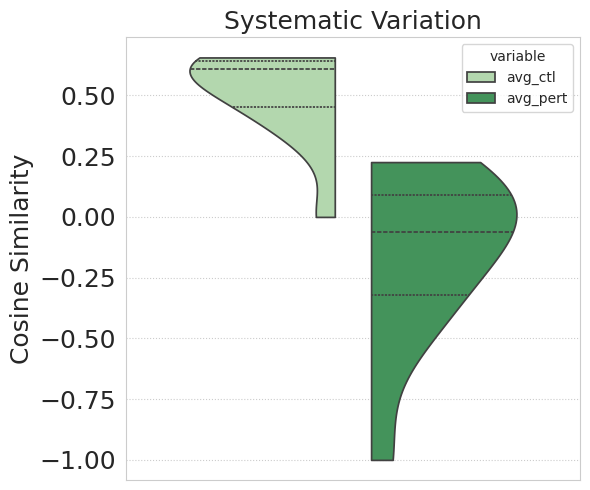

In [10]:
plot_systematic_variation(df, dataset_name, pert_names)

In [11]:
def print_systematic_variation_summary(df, df_pair, dataset_name, pert_names):

    print("=" * 80)
    print("SYSTEMATIC VARIATION SUMMARY")
    print("=" * 80)

    print(f"\nDataset: {dataset_name}")
    print(f"Number of perturbations: {len(pert_names)}")

    print(f"\n Summary by Reference Type:")
    summary = df.groupby('variable')['value'].agg(['mean', 'std', 'count', 'min', 'max'])
    for ref_type in summary.index:
        mean_val = summary.loc[ref_type, 'mean']
        std_val = summary.loc[ref_type, 'std']
        print(f"\n  {ref_type}:")
        print(f"    Mean:   {mean_val:.4f} ± {std_val:.4f}")
        print(f"    Range:  [{summary.loc[ref_type, 'min']:.4f}, {summary.loc[ref_type, 'max']:.4f}]")
        print(f"    Count:  {summary.loc[ref_type, 'count']}")

    # Show pairwise similarities if available
    if len(df_pair) > 0:
        print(f"\n Pairwise Similarities:")
        print(f"  Total pairs: {len(df_pair)}")
        if 'variable' in df_pair.columns:
            for var in df_pair['variable'].unique():
                subset = df_pair[df_pair['variable'] == var]
                print(f"  {var}: {subset['value'].mean():.4f} ± {subset['value'].std():.4f}")

    print("\n" + "=" * 80)

# Call the function
print_systematic_variation_summary(df, df_pair, dataset_name, pert_names)

SYSTEMATIC VARIATION SUMMARY

Dataset: boli_perturb_ctx_edit_ntsubset_hvg
Number of perturbations: 24

 Summary by Reference Type:

  avg_ctl:
    Mean:   0.5073 ± 0.1968
    Range:  [0.0000, 0.6562]
    Count:  12

  avg_pert:
    Mean:   -0.1494 ± 0.3530
    Range:  [-1.0000, 0.2256]
    Count:  12

 Pairwise Similarities:
  Total pairs: 132
  avg_ctl: 0.2160 ± 0.1932
  avg_pert: -0.0356 ± 0.2132



# boli_morphology_raw

In [12]:
adata2 = sc.read_h5ad("/gpfs/home/asun/jin_lab/database/boli_morphology/raw/adata.h5ad")

In [13]:
adata2.obs.columns


Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8',
       'seurat_clusters', 'Assign', 'Sample', 'scds', 'cxds', 'bcds',
       'nCount_refAssay', 'nFeature_refAssay', 'predicted.subclass.score',
       'predicted.subclass', 'RNA_snn_res.1.5', 'CT', 'mito', 'CT2', 'Top',
       'ident'],
      dtype='object')

In [14]:
df, df_pair, df_norm, pert_names = pre_process(adata2, "boli_morphology")
dataset_name = "boli_morphology"


df: (36, 4) df_pair: (306, 3) df_norm: (36, 4) #perts: 36
          count      mean       std  min       25%       50%       75%  \
variable                                                                 
avg_ctl    18.0  0.907087  0.230218  0.0  0.938649  0.970540  0.991483   
avg_pert   18.0 -0.102218  0.691083 -1.0 -0.741065 -0.124428  0.607391   

               max  
variable            
avg_ctl   0.997076  
avg_pert  0.818529  


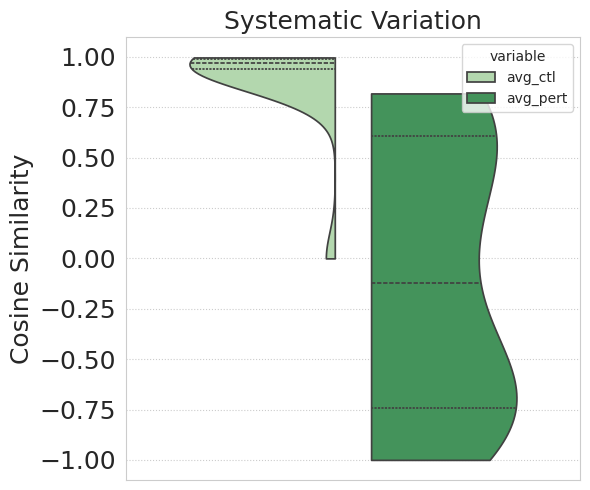

In [15]:
plot_systematic_variation(df, dataset_name, pert_names)

In [16]:
print_systematic_variation_summary(df, df_pair, dataset_name, pert_names)

SYSTEMATIC VARIATION SUMMARY

Dataset: boli_morphology
Number of perturbations: 36

 Summary by Reference Type:

  avg_ctl:
    Mean:   0.9071 ± 0.2302
    Range:  [0.0000, 0.9971]
    Count:  18

  avg_pert:
    Mean:   -0.1022 ± 0.6911
    Range:  [-1.0000, 0.8185]
    Count:  18

 Pairwise Similarities:
  Total pairs: 306
  avg_ctl: 0.8176 ± 0.3006
  avg_pert: 0.0364 ± 0.5840



# boli_morphology_processed

In [17]:
adata3 = sc.read_h5ad("/gpfs/home/asun/jin_lab/database/boli_morphology/processed/scanpy/adata.h5ad")

AnnDataReadError: Above error raised while reading key '/uns/log1p/base' of type <class 'h5py._hl.dataset.Dataset'> from /.

In [ ]:
adata2.obs.columns


Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8',
       'seurat_clusters', 'Assign', 'Sample', 'scds', 'cxds', 'bcds',
       'nCount_refAssay', 'nFeature_refAssay', 'predicted.subclass.score',
       'predicted.subclass', 'RNA_snn_res.1.5', 'CT', 'mito', 'CT2', 'Top',
       'ident'],
      dtype='object')

In [ ]:
df, df_pair, df_norm, pert_names = pre_process(adata2, "boli_morphology")
dataset_name = "boli_morphology"


df: (36, 4) df_pair: (306, 3) df_norm: (36, 4) #perts: 36
          count      mean       std  min       25%       50%       75%  \
variable                                                                 
avg_ctl    18.0  0.907087  0.230218  0.0  0.938649  0.970540  0.991483   
avg_pert   18.0 -0.102218  0.691083 -1.0 -0.741065 -0.124428  0.607391   

               max  
variable            
avg_ctl   0.997076  
avg_pert  0.818529  


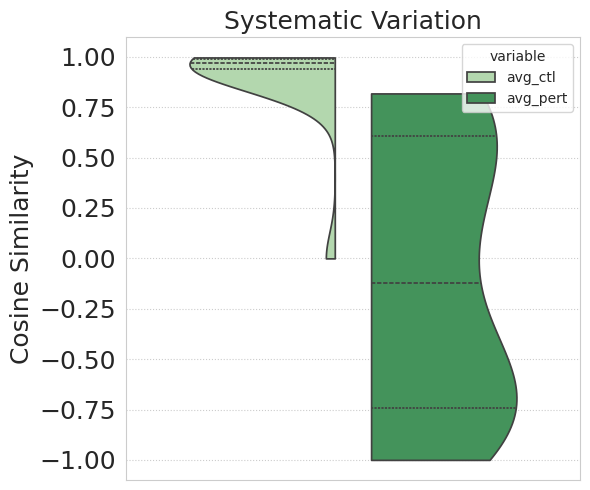

In [ ]:
plot_systematic_variation(df, dataset_name, pert_names)